In [1]:
import numpy as np
from scipy.optimize import minimize
from mygp import gp, kernel

import matplotlib.pyplot as pl
%matplotlib inline

# setup plotting
import seaborn as sns
palette = sns.color_palette()
sns.set()

In [2]:
def make_data(params, mean_func, n_samples, t):
    log_l = params[0]
    log_wn = params[1:n_samples+1]
    
    if n_samples > 1:
        c = np.concatenate(([1], params[n_samples+1: 2*n_samples]))
        mean_params = params[2*n_samples:]
        k2 = kernel.scale_kernel([scale for scale in c])
    else:
        mean_params = params[n_samples+1:]
        k2 = None

    mean = lambda x: mean_func(x, *mean_params)
    k1 = kernel.exp_sq_kernel(np.exp(log_l), 10)
    
    dim = (n_samples > 1) + 1
    g = gp(mean, k1, kernel2=k2, wn=[np.exp(lwn) for lwn in log_wn], dim=dim)
    g.compute(t)
    data = g.sample()
    return data

def neg_log_like(params, mean_func, n_samples, t, data):
    log_l = params[0]
    log_wn = params[1:n_samples+1]
    
    if n_samples > 1:
        c = np.concatenate(([1], params[n_samples+1: 2*n_samples]))
        mean_params = params[2*n_samples:]
        k2 = kernel.scale_kernel([scale for scale in c])
    else:
        mean_params = params[n_samples+1:]
        k2 = None
    
    mean = lambda x: mean_func(x, *mean_params)
    k1 = kernel.exp_sq_kernel(np.exp(log_l), 10)
    
    dim = (n_samples > 1) + 1
    g = gp(mean, k1, kernel2=k2, wn=[np.exp(lwn) for lwn in log_wn], dim=dim)
    g.compute(t)
    nll = -g.log_likelihood(data, x=t)
    return nll

def print_params(params, n_samples):
    log_l = params[0]
    log_wn = params[1:n_samples+1]
    
    if n_samples > 1:
        c = np.concatenate(([1], params[n_samples+1: 2*n_samples]))
        mean_params = params[2*n_samples:]
    else:
        mean_params = params[n_samples+1:]
        k2 = None
    
    print('mean parameters: ', mean_params)
    print('l: ', np.exp(log_l))
    print('white noise: ', np.exp(log_wn))
    if n_samples > 1:
        print('scale factor: ', c)
    
def fit_n_samples(p0, n_samples):
    func = lambda p: neg_log_like(p, gauss, n_samples, t, data)
    
    if n_samples > 1:
        log_bounds = [(-np.inf, np.inf) for i in range(n_samples+1)]
        reg_bounds = [(0, np.inf) for i in range(n_samples-1)]
        mean_bounds = [(0, np.inf) for i in range(2)]
        bounds = np.concatenate((log_bounds, reg_bounds, mean_bounds))
    
    else: 
        bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf), (0, np.inf)]
    
    min_params = minimize(func, x0=p0, bounds=bounds, method='L-BFGS-B')
    return min_params.x

/Users/tgordon/research/gp2d/mygp.py:194: RuntimeWarning: overflow encountered in double_scalars
  self.detK = np.prod(np.diag(self.L))**2


True Parameters
---------------
mean parameters:  (20, 3.5)
l:  0.5
white noise:  [4. 4. 6.]
scale factor:  [1 2 4]


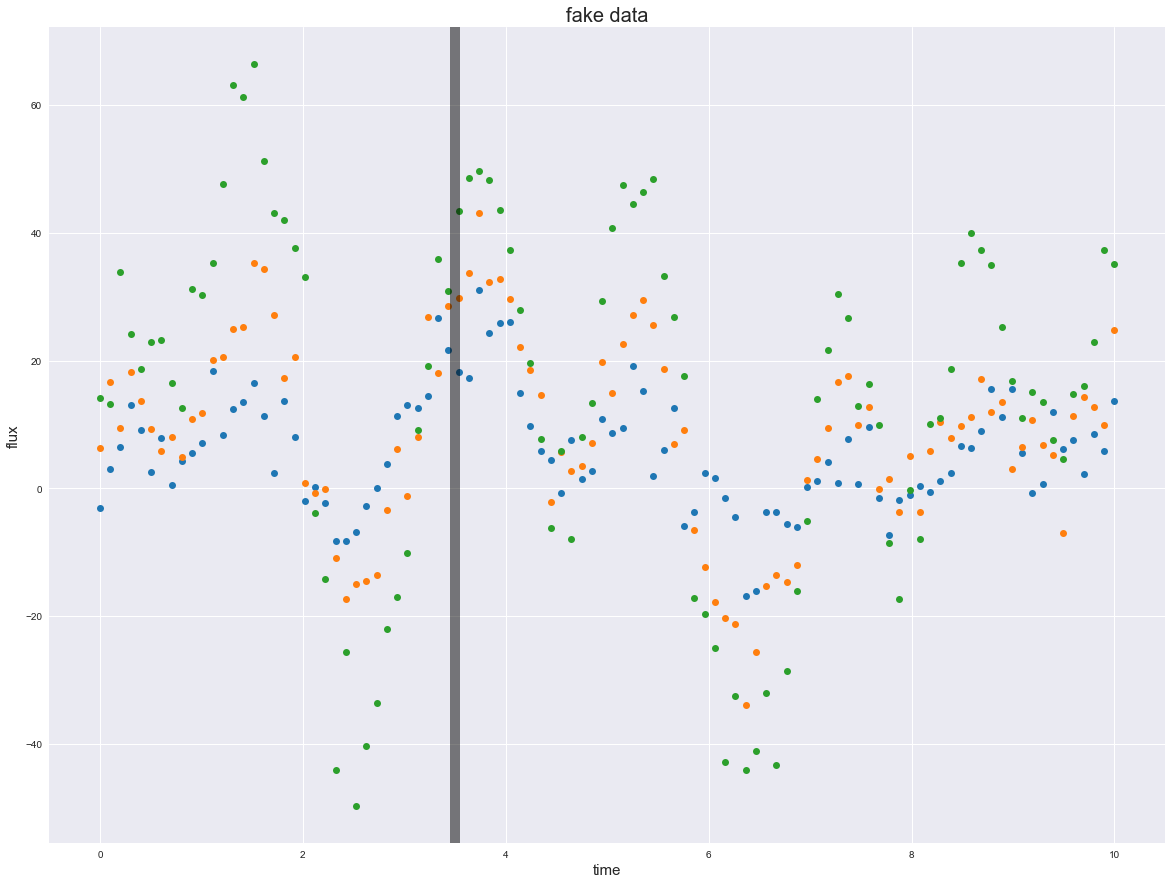

In [5]:
t0 = 3.5
true_params = np.log(0.5), np.log(4), np.log(4), np.log(6), 2, 4, 20, t0
t = np.linspace(0, 10, 100)

def gauss(t, A, t0):
    return A*np.exp(-(t - t0)**2)

data = make_data(true_params, gauss, 3, t)

# plot the data
fig = pl.figure(figsize=(20, 15))
pl.plot(t, data[0], 'o', alpha=1, color=palette[0])
pl.plot(t, data[1], 'o', alpha=1, color=palette[1])
pl.plot(t, data[2], 'o', alpha=1, color=palette[2])
pl.axvline(t0, linewidth=10, color='k', alpha=0.5)


pl.title('fake data', size=20)
pl.xlabel('time', size=15)
pl.ylabel('flux', size=15)

print('True Parameters')
print('---------------')
print_params(true_params, 3)

/Users/tgordon/research/gp2d/mygp.py:194: RuntimeWarning: overflow encountered in double_scalars
  self.detK = np.prod(np.diag(self.L))**2


Best Fit Parameters
---------------
mean parameters:  [19.06064559  3.54410078]
l:  0.5261140026064944
white noise:  [4.45918876 4.35722975 6.06221101]
scale factor:  [1.         2.13434831 4.25776086]


Text(0,0.5,'flux')

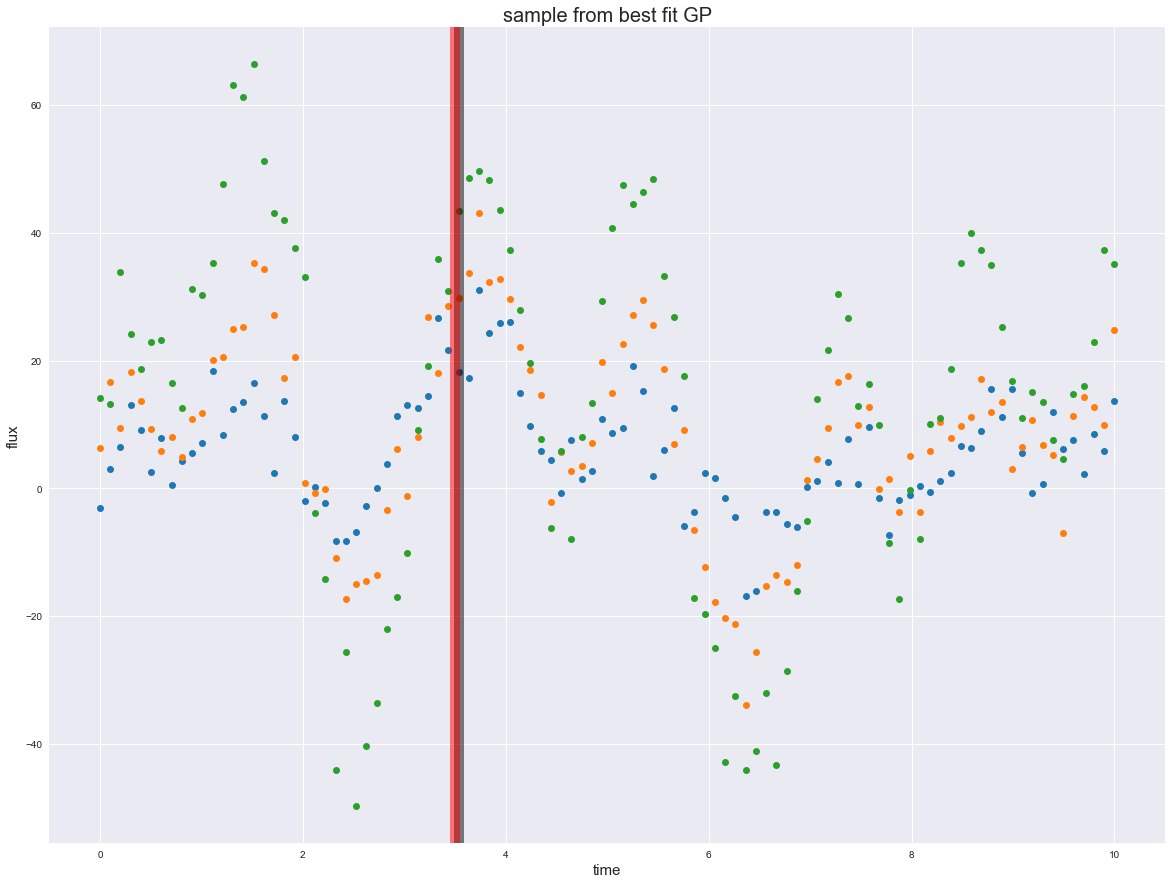

In [6]:
p0 = [np.log(0.4), np.log(0.7), np.log(3.5), np.log(4.5), 1.5, 3, 50, 5]
min_params = fit_n_samples(p0, 3)

# compute best fit GP
samp = make_data(min_params, gauss, 3, t)
y1, y2, y3 = samp

print('Best Fit Parameters')
print('---------------')
print_params(min_params, 3)

# plot a sample from best fit GP
fig = pl.figure(figsize=(20, 15))
#pl.plot(t, y1, 'o', alpha=1, color=palette[0])
#pl.plot(t, y2, 'o', alpha=1, color=palette[1])
#pl.plot(t, y3, 'o', alpha=1, color=palette[2])
pl.plot(t, data[0], 'o', alpha=1, color=palette[0])
pl.plot(t, data[1], 'o', alpha=1, color=palette[1])
pl.plot(t, data[2], 'o', alpha=1, color=palette[2])
pl.axvline(min_params[-1], linewidth=10, color='k', alpha=0.5)
pl.axvline(t0, linewidth=10, color='r', alpha=0.5)

pl.title('sample from best fit GP', size=20)
pl.xlabel('time', size=15)
pl.ylabel('flux', size=15)

In [ ]:
t = np.linspace(0, 10, 300)
true_params = np.log(0.5), np.log(5), 50, 3.5
data = make_data(true_params, gauss, 1, t)

fig = pl.figure(figsize=(20, 15))
pl.plot(t, data, 'o', alpha=1, color=palette[0])
pl.title('fake data', size=20)
pl.xlabel('time', size=15)
pl.ylabel('flux', size=15)

In [ ]:
p0 = [np.log(0.4), np.log(0.7), 100, 5]
min_params = fit_n_samples(p0, 1)

# compute best fit GP
samp = make_data(min_params, gauss, 1, t)

print('Best Fit Parameters')
print('---------------')
print_params(min_params, 1)

# plot a sample from best fit GP
fig = pl.figure(figsize=(20, 15))
pl.plot(t, samp, 'o', alpha=1, color=palette[0])
pl.title('sample from best fit GP', size=20)
pl.xlabel('time', size=15)
pl.ylabel('flux', size=15)

In [ ]:
import astropy.constants as ac
import batman

def transit_model(params, t):
    p = batman.TransitParams()
    p.t0, p.per, p.rp, p.a, p.inc, p.ecc, p.w, u0, u1 = params
    p.u = [u0, u1]
    p.limb_dark = "quadratic"
    planet = batman.TransitModel(p, t)
    return planet.light_curve(p)

per = 10
t0 = t.min() + (t.max()-t.min())/2. - per
mp_ratio = 0.5
rp = (10*ac.R_earth.value/(ac.R_sun.value))
a = 0.1
a_stellar_rad = a * ac.au.value/(ac.R_sun.value)
inc = 88
ecc = 0
w = 90
u0 = 0.2
u1 = 0.2
planet = transit_model([t0, per, rp, a_stellar_rad, inc, ecc, w, u0, u1], t)